In [1]:
# Necessary imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns


# Plotting setup
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

# Keep the machine usable during training by limiting the GPU memory usage
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Get data

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


# Quick look at the data

The Fashion MNIST dataset includes:

1. 60,000 training examples
2. 10,000 testing examples
3. 10 classes
4. 28×28 grayscale/single channel images

The ten fashion class labels include:

1. T-shirt/top
2. Trouser/pants
3. Pullover shirt
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot


In [227]:
x_train.shape

(60000, 28, 28, 1)

In [228]:
y_train.shape

(60000,)

### Reshape data to match the input requirements 

### Check the distribution

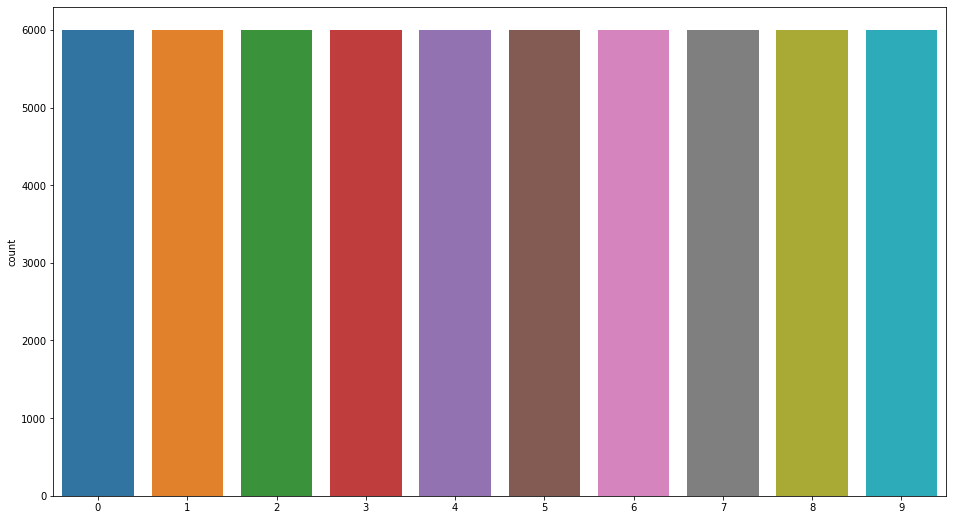

In [20]:
g = sns.countplot(y_train, )

Since the examples are evenly distributed between classes we do not need to stratified sampling. 

### Check for NaNs

Once again, since we are dealing with a training dataset we do not expect any null values. We still check, for the sake of completeness

In [26]:
print(np.isnan(x_train).any())

False


# Create model

A standard conv-net with 3 layers and drop-out/normalization between each layer will be used.

In [5]:
# add empty color dimension
# Change shape from (60000, 28, 28) to (60000, 28, 28, 1)
# (number_of_images, image_height, _image_width, channels)
x_train = np.expand_dims(x_train, -1) 
x_test = np.expand_dims(x_test, -1)
x_train.shape

(60000, 28, 28, 1)

### Define callbacks

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# To prevent overfitting the training will be stopped if the val_loss has not decreased in 5 epochs
earlystop = EarlyStopping(patience=5) 

# Decrease learning rate if the accuracy is not increased for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [45]:
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense


def create_model():
    model = Sequential()

    # Add layers
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [46]:
history = model.fit(
    x_train.astype(np.float32),
    y_train.astype(np.float32),
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=1,
    epochs=40,
    callbacks=callbacks
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 22s 364us/sample - loss: 0.5512 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.3568 - val_sparse_categorical_accuracy: 0.8640
Epoch 2/40
60000/60000 [==============================] - 21s 348us/sample - loss: 0.3697 - sparse_categorical_accuracy: 0.8676 - val_loss: 0.3220 - val_sparse_categorical_accuracy: 0.8770
Epoch 3/40
60000/60000 [==============================] - 21s 342us/sample - loss: 0.3323 - sparse_categorical_accuracy: 0.8808 - val_loss: 0.2969 - val_sparse_categorical_accuracy: 0.8914
Epoch 4/40
60000/60000 [==============================] - 20s 340us/sample - loss: 0.3012 - sparse_categorical_accuracy: 0.8907 - val_loss: 0.2856 - val_sparse_categorical_accuracy: 0.8966
Epoch 5/40
60000/60000 [==============================] - 21s 356us/sample - loss: 0.2842 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.2664 - val_sparse_categorical_accuracy: 0.9026
Epoch

We are able to obtain above 93% accuracy after 21 epochs(7 minutes of training on GTX1060 GPU), which is enough for our purposes. In order to further increase the accuracy we could try adding more layers, but this would in turn increase the size and complexity of the model, thus increasing the time required to make a prediction. 

## Save created model

In [15]:
tf.saved_model.save(model, "../model/1/")

INFO:tensorflow:Assets written to: ../model/1/assets


# Evaluate Model

## Plot training history

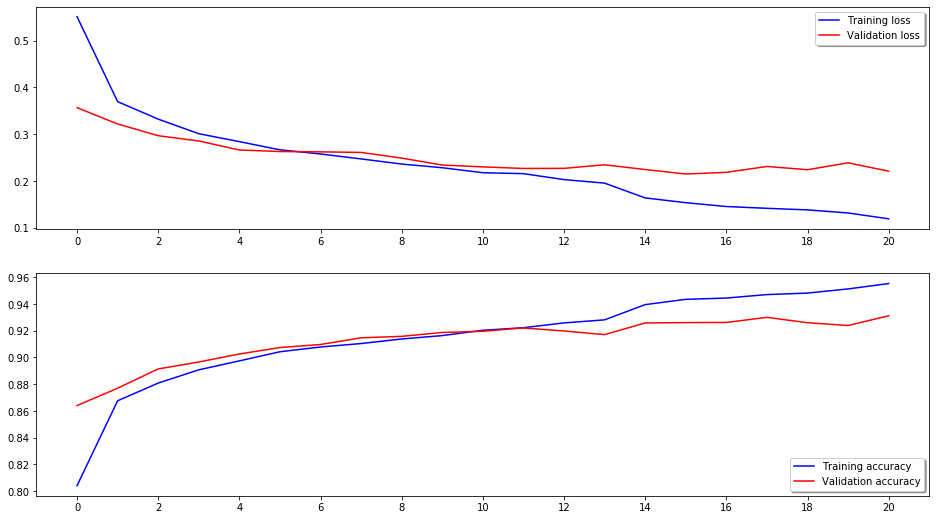

In [69]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
plt.setp(ax, xticks = np.arange(0, 22, step=2))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='upper right', shadow=True)

ax[1].plot(history.history['sparse_categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_sparse_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='lower right', shadow=True)

The training has been stopped after the validation loss has not decreased in 5 iterations. The accuracy on training set was still increasing which could indicate possible overfitting if the model was trained for longer. 

For longer and more complex training TensorBoard would be a much better solution for providing visualizations of the learning process. It can be set up by providing additional callback to the model. 

# Confussion matrix

In [97]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(x_test.astype(np.float32))
predictions = [i.argmax() for i in predictions]

Text(123.0, 0.5, 'Actual')

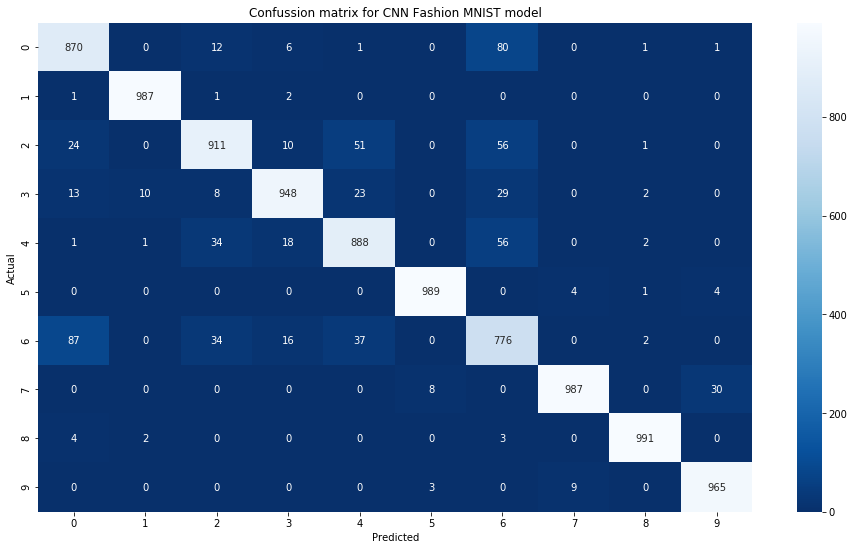

In [99]:
matrix = confusion_matrix(predictions, y_test)
plt.figure(figsize=(16,9))
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues_r')
plt.title('Confussion matrix for CNN Fashion MNIST model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

On the confusion matrix we can see that we are getting very high accuracy for majority of classess. The most troublesome is class 6 - shirt, which is usually confused with T-shirt and vice versa. These two classes are very similiar to each other and could be problematic to distinguish even for a human when viewed as an 28x28 image.

# Prepare data for testing the deployment

### Save test json payload with 10 images

In [222]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:10].tolist()})
with open('../deploy/test.json', 'w') as f:
    json.dump(data, f)

### Save labels for testing

In [226]:
np.savetxt('../deploy/labels.csv', y_test[0:10].astype(int), fmt='%i', delimiter=',')